In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
ROWS = 100
COLS = 100
MAX_HEIGHT = 75

In [3]:
# Random
np.random.seed(42)
random_terrain = np.random.randint(low=0, high=MAX_HEIGHT, size=(ROWS, COLS))

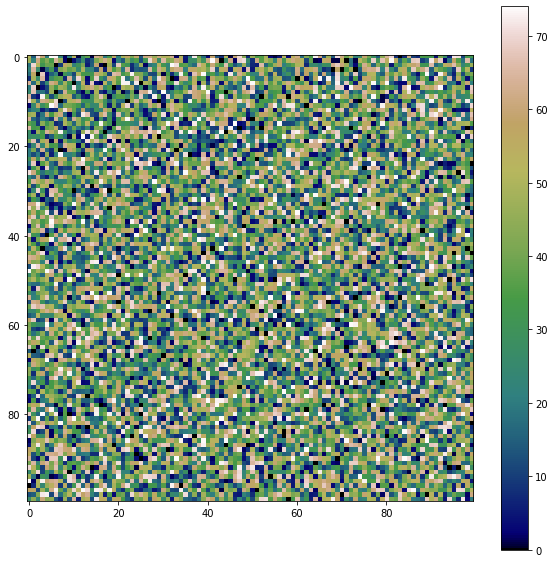

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(random_terrain, cmap='gist_earth', interpolation='nearest')
plt.colorbar()
plt.show()

In [5]:
# Probably not worth it to run experiments on a radnom terrain...

In [6]:
# Let us try Perlin noise

In [7]:
from perlin_noise import PerlinNoise

In [8]:
noise = PerlinNoise(octaves=10, seed=1)
terrain = [[noise([i/ROWS, j/COLS]) for j in range(ROWS)] for i in range(COLS)]

In [9]:
min(min(terrain)), max(max(terrain))

(-0.4296870375950202, 0.42131280369009316)

In [10]:
# We want heights to be in the range [0, 75] and to be integers.

In [11]:
import math
minimum = min(min(terrain))
maximum = max(max(terrain))
scaling_factor = MAX_HEIGHT / (maximum + minimum + 1)
f = np.vectorize(lambda x: math.floor((x + minimum + 1) * scaling_factor))
discrete_terrain = f(terrain)

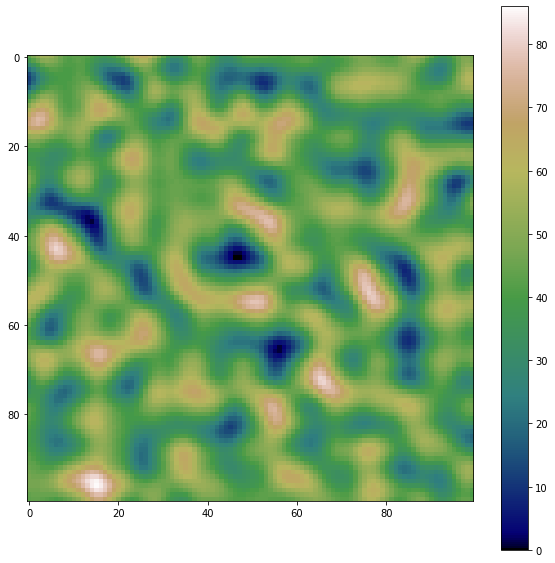

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(discrete_terrain, cmap='gist_earth')
plt.colorbar()
plt.show()

In [13]:
# Terrain is a singleton.
from typing import Iterable
from typing import Tuple, List
from typing import Callable

Terrain = Iterable[Iterable[int]]

In [14]:
class Agent:
    """Mountain climber.
       TODO: improve docs and fix typing?
    """
    
    def __init__(
        self,
        x: int,
        y: int,
        reach: int,
        neighborhood_type: Callable,
        climbing_technique: Callable,
        rows: int,
        cols: int,
        terrain: Terrain
    ):
        self.x = x
        self.y = y
        self.reach = reach
        self.neighborhood_type = neighborhood_type
        self.climbing_technique = climbing_technique
        self.rows = rows
        self.cols = cols
        self.terrain = terrain
    
    
    def get_neighbors(self):
        return self.neighborhood_type(self.x, self.y, self.rows, self.cols, self.terrain)
    
    
    def set_position(self, new_x, new_y):
        self.x = new_x
        self.y = new_y
    
    
    def climb(self):
        current_height = self.terrain[self.x][self.y]
        new_position = self.climbing_technique(self.x, self.y, self.reach, self.get_neighbors(), current_height)
        self.set_position(*new_position)


In [15]:
def moore_neighberhood(x: int, y: int, rows: int, cols: int, terrain: Terrain) -> List[Tuple[int, int, int]]:
    """Return a tuple containing neighbors coordinates and height.
    """
    in_bounds = lambda x, y: 0 <= x < rows and 0 <= y < cols
    neighbors = []
    for i in range(-1, 2):
        for j in range(-1, 2):
            row = x+i
            col = y+j
            if in_bounds(row, col) and (i != 0 or j != 0):
                neighbors.append(tuple((row, col, terrain[row][col])))
    return neighbors


def von_neumann_neighberhood(x: int, y: int, rows: int, cols: int, terrain: Terrain) -> List[Tuple[int, int, int]]:
    in_bounds = lambda x, y: 0 <= x < rows and 0 <= y < cols
    neighbors = []
    for i in range(-1, 2):
        for j in range(-1, 2):
            row = x+i
            col = y+j
            if in_bounds(row, col) and (i == 0 or j == 0) and i != j:
                neighbors.append(tuple((row, col, terrain[row][col])))
    return neighbors

In [16]:
import random

def climb_steepest(
    x: int,
    y: int,
    reach: int,
    neighbors: List[Tuple[int, int, int]],
    current_height: int
) -> Tuple[int, int]:
    """Go to the tallest point in the neighborhood within reach.
    """
    
    possible_directions = [(x, y, height - current_height) for (x, y, height) in neighbors
                           if 0 <= height - current_height <= reach]
    if possible_directions:
        steepest = max(possible_directions, key=lambda x_y_diff: x_y_diff[2])
        return steepest[:2]
    else:
        return tuple((x, y))




def climb_steepest_or_random(threshold: float) -> Callable:
    def climb(
        x: int,
        y: int,
        reach: int,
        neighbors: List[Tuple[int, int, int]],
        current_height: int
    ) -> Tuple[int, int]:

        possible_directions = [(x, y, height - current_height) for (x, y, height) in neighbors
                               if height - current_height <= reach]
        if possible_directions:
            if random.random() < threshold:
                index = random.randrange(len(possible_directions))
                return possible_directions[index][:2]
            else:
                steepest = max(possible_directions, key=lambda x_y_diff: x_y_diff[2])
                if steepest[2] > 0:
                    return steepest[:2]
                else:
                    return tuple((x, y))
        else:
            return tuple((x, y))
        
    return climb


In [17]:
agent = Agent(10, 90, 10, moore_neighberhood, climb_steepest_or_random(0.5), ROWS, COLS, discrete_terrain)

In [18]:
x, y = 10, 90
for i in range(-1, 2):
    for j in range(-1, 2):
        x_ = x + i
        y_ = y + j
        print(discrete_terrain[x_][y_], end=" ")
    print("")

42 43 44 
42 43 43 
40 41 42 


In [19]:
agent.x, agent.y

(10, 90)

In [20]:
agent.climb()

In [21]:
agent.x, agent.y

(9, 91)

In [22]:
discrete_terrain[agent.x][agent.y]

44

In [23]:
x, y = agent.x, agent.y
for i in range(-1, 2):
    for j in range(-1, 2):
        x_ = x + i
        y_ = y + j
        print(discrete_terrain[x_][y_], end=" ")
    print("")

42 43 43 
43 44 45 
43 43 44 


In [24]:
agent.climb()

In [35]:
agent.x, agent.y

(8, 90)

In [36]:
discrete_terrain[agent.x][agent.y]

42

In [37]:
# --- animation ---

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
from IPython.display import HTML
import itertools

In [39]:
# --- test terrain ---

In [40]:
test_terrain = np.zeros((ROWS, COLS))

In [41]:
# (10,10) -> (10,90)
# (10,90) -> (50,90)
# (50,90) -> (50,10)
# (50,10) -> (90,10)
# (90,10) -> (90,90)

In [42]:
def integers():
    n = 0
    while True:
        n += 1
        yield n


In [43]:
ints = integers()

In [44]:
v1 = [next(ints) for i in range(80)]

In [45]:
test_terrain[10][10:90] = v1

In [46]:
v2 = [next(ints) for i in range(40)]

In [47]:
test_terrain[10:50, 90] = v2

In [48]:
v3 = [next(ints) for i in range(80)]

In [49]:
test_terrain[49][10:90] = list(reversed(v3))

In [50]:
v4 = [next(ints) for i in range(40)]

In [51]:
test_terrain[49:89, 10] = v4

In [52]:
v5 = [next(ints) for i in range(80)]

In [53]:
test_terrain[89][10:90] = v5

In [54]:
test_terrain2 = np.zeros((ROWS, COLS, 3))

In [55]:
np.max(test_terrain)

320.0

In [56]:
maximum = np.max(test_terrain)
for i in range(ROWS):
    for j in range(COLS):
        test_terrain2[i][j] = (0, test_terrain[i][j]/maximum, 0)

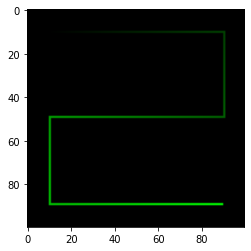

In [57]:
plt.imshow(test_terrain2)

In [58]:
agents_color = (1, 0, 0)

In [59]:
agent = Agent(10, 10, 10, moore_neighberhood, climb_steepest, ROWS, COLS, test_terrain)

In [60]:
agents_positions = []
changing = True
while changing:
    current_position = (agent.x, agent.y)
    agents_positions.append(current_position)
    agent.climb()
    changing = current_position != (agent.x, agent.y)


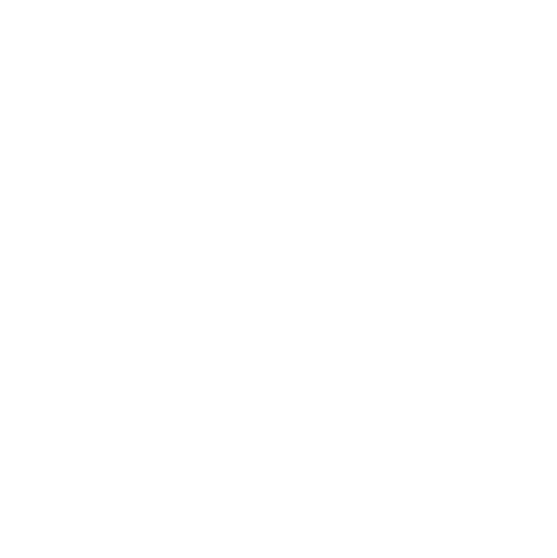

In [68]:
fig, ax = plt.subplots(figsize=(10,10))
plt.axis('off')
ims = []
for pos in agents_positions:
    frame = np.copy(test_terrain2)
    x, y = pos
    frame[x][y] = agents_color
    im = ax.imshow(frame, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

In [69]:
HTML(ani.to_html5_video())

In [70]:
ani.save("test_terrain.mp4")

In [25]:
# Generate some terrains to test

In [227]:
test_terrain1 = np.zeros((ROWS, COLS))

In [228]:
for i in range(ROWS):
    for j in range(COLS):
        test_terrain1[i][j] = i+j

In [229]:
with open('test_terrain1.npy', 'wb') as f:
    np.save(f, test_terrain1)

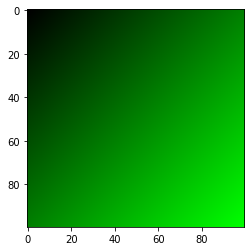

In [230]:
with open('test_terrain1.npy', 'rb') as f:
    terrain = np.load(f)
    norm_terrain = np.zeros((terrain.shape[0], terrain.shape[1], 3))
    maximum = np.max(terrain)
    for i in range(ROWS):
        for j in range(COLS):
            norm_terrain[i][j] = (0, terrain[i][j]/maximum, 0)
    plt.imshow(norm_terrain)

In [39]:
test_terrain2 = np.zeros((ROWS, COLS))

In [102]:
for i in range(ROWS):
    for j in range(COLS//4):
        test_terrain2[i][j] = j

for i in range(ROWS):
    for j in range(COLS//4, COLS//4+3):
        test_terrain2[i][j] = COLS//4 - (j % 4) - 1

for i in range(ROWS):
    for j in range(COLS//4+3, COLS):
        test_terrain2[i][j] = j-6

In [103]:
with open('test_terrain2.npy', 'wb') as f:
    np.save(f, test_terrain2)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 23. 22. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.
 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.
 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83.
 84. 85. 86. 87. 88. 89. 90. 91. 92. 93.]


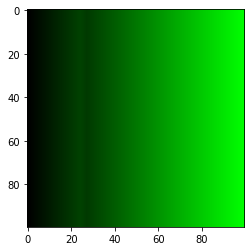

In [104]:
with open('test_terrain2.npy', 'rb') as f:
    terrain = np.load(f)
    norm_terrain = np.zeros((terrain.shape[0], terrain.shape[1], 3))
    maximum = np.max(terrain)
    for i in range(ROWS):
        for j in range(COLS):
            norm_terrain[i][j] = (0, terrain[i][j]/maximum, 0)
    plt.imshow(norm_terrain)
    print(terrain[0])

In [247]:
with open('test_terrain2.npy', 'rb') as f:
    terrain = np.load(f)
    print(np.max(terrain))
    print(terrain[:,COLS//4])

49.0
[25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25.
 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25.
 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25.
 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25.
 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25.
 25. 25. 25. 25. 25. 25. 25. 25. 25. 25.]


In [244]:
COLS//4

25

In [ ]:
# initialize column # initialize quadrant 

In [248]:
discrete_terrain

array([[43, 48, 52, ..., 49, 49, 47],
       [37, 42, 46, ..., 49, 50, 48],
       [29, 34, 39, ..., 50, 52, 51],
       ...,
       [46, 46, 46, ..., 42, 43, 41],
       [44, 45, 45, ..., 42, 42, 40],
       [43, 44, 44, ..., 44, 44, 42]])

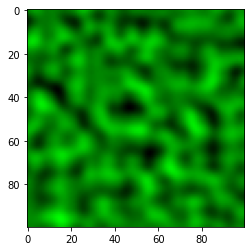

In [252]:
norm_terrain = np.zeros((ROWS, COLS, 3))
maximum = np.max(discrete_terrain)
for i in range(ROWS):
    for j in range(COLS):
        norm_terrain[i][j] = (0, discrete_terrain[i][j]/maximum, 0)
plt.imshow(norm_terrain)

In [253]:
with open('test_terrain3.npy', 'wb') as f:
    np.save(f, discrete_terrain)

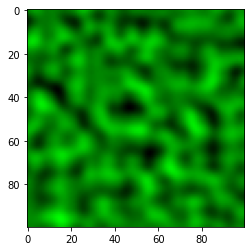

In [254]:
with open('test_terrain3.npy', 'rb') as f:
    terrain = np.load(f)
    norm_terrain = np.zeros((terrain.shape[0], terrain.shape[1], 3))
    maximum = np.max(terrain)
    for i in range(ROWS):
        for j in range(COLS):
            norm_terrain[i][j] = (0, terrain[i][j]/maximum, 0)
    plt.imshow(norm_terrain)

In [71]:
def random_dist(n, ROWS, COLS):
    return [(random.randrange(ROWS), random.randrange(COLS)) for i in range(n)]

In [72]:
random_dist(10, 100, 100)

[(68, 38),
 (47, 34),
 (59, 61),
 (85, 91),
 (91, 30),
 (80, 34),
 (93, 8),
 (86, 95),
 (84, 29),
 (3, 69)]

In [73]:
def quadrant_init(n, ROWS, COLS):
    return [(random.randrange(ROWS//4), random.randrange(COLS//4)) for i in range(n)]

In [74]:
quadrant_init(10, 100, 100)

[(17, 13),
 (13, 12),
 (9, 0),
 (6, 2),
 (16, 8),
 (24, 6),
 (4, 13),
 (16, 8),
 (23, 16),
 (21, 18)]

In [76]:
def first_col(n, ROWS, COLS):
    return [(random.randrange(ROWS), 0) for i in range(n)]

In [77]:
first_col(10, 100, 100)

[(96, 0),
 (9, 0),
 (35, 0),
 (21, 0),
 (82, 0),
 (41, 0),
 (33, 0),
 (94, 0),
 (26, 0),
 (12, 0)]

In [78]:
test_terrain1 = np.zeros((ROWS, COLS))

In [79]:
for i,j in first_col(10, 100, 100):
    test_terrain1[i][j] = 1

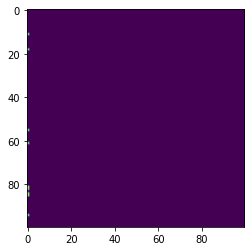

In [80]:
plt.imshow(test_terrain1)